# Optic flow estimation from an image pair

In this notebook, we will explain how to estimate optic flow from an image pair coming from a conventional camera. There are many different optic flow algorithms, ranging from exhaustive block-matching to variational methods, and from phase-based methods to deep neural networks. However, in our explanation, we will focus on the most common, CPU-based, _feature-based method_ that performs two steps:
<OL>
    <LI> Feature detection </LI>
    <LI> Feature tracking </LI>
</OL>

In this notebook, we will start with the second step, as it is the one that actually determines the optic flow. In particular, we will explain the method developed by Lucas and Kanade [1], which is both a fast and accurate method for determining optic flow.

## Lucas and Kanade's algorithm for optic flow determination
In their article, Lucas and Kanade first explain their method with a one-dimensional example. We will do the same here. Below, we show two curves, $f(x)$ and $g(x)$, which only differ by a horizontal shift, i.e., $g(x)=f(x+h)$, where $h$ is the the horizontal shift. The vertical axis is termed $I$ for illuminance. The fact that the curves have the exact same illuminance shows that it constant brightness is assumed. 

<IMG SRC="LucasKanade_flow.png" WIDTH="50%"></IMG>

So, we have:

\begin{equation}
g(x) = f(x+h)
\end{equation}
<div style="text-align: right">(Eq. 1)</div>

The basis for the Lucas and Kanade method is a linear approximation:

\begin{equation}
f'(x) \approx \frac{f(x+h) - f(x)}{h}
\end{equation}
<div style="text-align: right">(Eq. 2)</div>

where we can use equation 1 to arrive at:

\begin{equation}
f'(x) \approx \frac{g(x) - f(x)}{h}
\end{equation}
<div style="text-align: right">(Eq. 3)</div>

and by re-arranging terms:

\begin{equation}
h \approx \frac{g(x) - f(x)}{f'(x)}
\end{equation}
<div style="text-align: right">(Eq. 4)</div>

Eq. 4 is the basic step in the Lucas and Kanade algorithm. Explained on an intuitive level: If function $g$ is higher at $x$ than $f$, and $f'(x)$ is positive, then $h$ should be augmented in order to shift $f$ further to the left to better match $g$. Similar reasonings can be follow for $g$ being lower than $f$ and $f'(x)$ being positive or negative. Both the underlying math and the intuitive explanation immediately show that this method strongly relies on local approximations.

<font color='red'><B>Exercise 1.</B></font> You are now going to explore the characteristics of the very elementary form of the LK method as presented in Eq. 4. 

1. Please have a look at the code. Halfway the code, you will find a variable `x_query`, which is now set to 3. If you run the code, you will see that the optic flow estimated at that location corresponds quite well to the ground truth value of 0.5. Set `x_query` to different values. Try to make the algorithm fail. Under what conditions does it fail?

2. Now change the function properties. Can you make a function for which the method will always fail? And a function for which the estimate will always be wrong when the shift is bigger than a given threshold? What do these situations correspond to, if the function values correspond to actual pixel values in a real image? 

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

def fun(x, offset=10, slope = -0.5, a = 1, fun_type = 'sine_slope'):    
    
    if(fun_type == 'sine_slope'):
        y = offset + slope * x + np.sin(a * x)
    elif(fun_type == 'quadratic'):
        y = offset + slope * x + a * x**2
    elif(fun_type == 'linear'):
        y = offset + slope * x
        
    return y

# ground-truth shift:
dx = 0.5

# properties of the function
fun_type = 'quadratic'
offset= 10 #10
slope = 0 #-0.5
a = 2

# range in which we show the function:
max_x = 3
step = 0.01 

# We take a simple 1D function and shift it in the x-axis:
x = np.arange(-max_x, max_x, step)
f = fun(x, offset, slope, a, fun_type)
g = fun(x+dx, offset, slope, a, fun_type)

# Plot the functions
plt.figure()
plt.plot(x, f, x, g)
plt.xticks(np.arange(-max_x, max_x,1))
plt.grid()
plt.legend(['f', 'g'])
plt.show()

# x coordinate at which we apply Eq. 4:
x_query = 2

# Determine f'(x) and apply Eq. 4:
small = 0.01
df_dx = (fun(x_query+small, offset, slope, a, fun_type) - fun(x_query, offset, slope, a, fun_type)) / small
h = (fun(x_query+dx, offset, slope, a, fun_type) - fun(x_query, offset, slope, a, fun_type)) / df_dx

# Output result:
print(f'Lucas and Kanade say that the shift at {x_query} = {h}, while the ground truth is {dx}')

### Wider support for determining optic flow

Normally the Lucas Kanade method determines optic flow by evaluating not a single pixel but a window. A naive way of using multiple pixels would be to average the proposed shifts:

\begin{equation}
h \leftarrow \frac{\sum_{x \in W} \frac{g(x) - f(x)}{f'(x)}}{\sum_{x \in W} 1}
\end{equation}
<div style="text-align: right">(Eq. 5)</div>

In [1], it is remarked that the approximation in Eq. 2 is most accurate if $f''(x)$ is small:

\begin{equation}
f''(x) \approx \frac{g'(x) - f'(x)}{h}
\end{equation}
<div style="text-align: right">(Eq. 6)</div>

Hence, it is proposed to use the following weight (since $h$ is the same for each pixel, it is omitted):

\begin{equation}
w(x) = \frac{1}{|g'(x) - f'(x)|}
\end{equation}
<div style="text-align: right">(Eq. 7)</div>

Leading to a weighted estimate:

\begin{equation}
h \leftarrow \frac{\sum_{x \in W} w(x) \frac{\left( g(x) - f(x) \right)}{f'(x)}}{\sum_{x \in W} w(x)}
\end{equation}
<div style="text-align: right">(Eq. 8)</div>

<font color='red'><B>Exercise 2.</B></font>
1. We have implemented both weighing schemes (Eqq. 5, 8). By changing the query coordinate, try to find out which scheme works better. Are there some coordinates where the weighted schemes still work badly? Try out both the quadratic and sine slope functions.


In [ ]:
# ground-truth shift:
dx = 0.5

# properties of the function
fun_type = 'quadratic'
offset= 10 #10
slope = 0 #-0.5
a = 2

#fun_type = 'sine_slope'
#offset= 5
#slope = 0.5
#a = 1

# range in which we show the function:
max_x = 3
step = 0.01 

# properties of the window:
window_half_size = 1
window_size = 2 * window_half_size + 1
window_step = 0.25

# We take a simple 1D function and shift it in the x-axis:
x = np.arange(-max_x, max_x, step)
f = fun(x, offset, slope, a, fun_type)
g = fun(x+dx, offset, slope, a, fun_type)

# Plot the functions
plt.figure()
plt.plot(x, f, x, g)
plt.xticks(np.arange(-max_x, max_x,1))
plt.grid()
plt.legend(['f', 'g'])
plt.show()

# x coordinate at which we apply Lucas Kanade:
x_query = 2

estimates = np.zeros([window_size, 1])
weights = np.zeros([window_size, 1])

small = 0.01
i = 0
for st in np.arange(x_query-window_step, x_query+1.5*window_step, window_step):
    df_dx = (fun(st+small, offset, slope, a, fun_type) - fun(st, offset, slope, a, fun_type)) / small
    h = (fun(st+dx, offset, slope, a, fun_type) - fun(st, offset, slope, a, fun_type)) / df_dx
    estimates[i] = h
    print(f'Estimate at {st} = {h}')
    
    dg_dx = (fun(st+dx+small, offset, slope, a, fun_type) - fun(st+dx, offset, slope, a, fun_type)) / small
    nom = np.abs(dg_dx - df_dx)
    print(f'df_dx = {df_dx}, dg_dx = {dg_dx}, nominator = {nom}')
    if(nom > 1E-3):
        weights[i] = 1 / nom
    else:
        weights[i] = 1E3
    print(f'Weight at {st} = {weights[i]}')
    i += 1

h_Eq5 = np.mean(estimates)
h_Eq8 = np.dot(np.transpose(weights), estimates) / np.sum(weights) 
h_Eq8 = h_Eq8[0][0]

# Output result:
print(f'Averaging the windows estimates at {x_query} leads to {h_Eq5}, while the ground truth is {dx}')
print(f'Weighing the windows estimates at {x_query} leads to {h_Eq8}, while the ground truth is {dx}')

### Reformulation
Lucas and Kanade subsequently reformulate the estimation, to prevent division by zero and ensure generalization to two dimensions. They start with:

\begin{equation}
f(x+h) \approx f(x) + h f'(x)
\end{equation}
<div style="text-align: right">(Eq. 9)</div>

And then want to minimize the quadratic error:

\begin{equation}
E = \sum_x \left( f(x+h) - g(x) \right)^2
\end{equation}
<div style="text-align: right">(Eq. 10)</div>

This can be done by setting its derivative to zero:

\begin{equation}
0 = \frac{\delta E}{ \delta h} = \frac{\delta}{ \delta h} \sum_x \left( f(x) + h f'(x) - g(x) \right)^2 = \sum_x 2 f'(x) \left( f(x) + h  f'(x) - g(x) \right) 
\end{equation}
<div style="text-align: right">(Eq. 11)</div>

From which we can get:

\begin{equation}
h = \frac{\sum_x f'(x) \left( g(x) - f(x) \right) }{\sum_x f'(x)^2}
\end{equation}
<div style="text-align: right">(Eq. 12)</div>

This reformulation leads to a different weighting, with $w(x) = f'(x)^2$.

<font color='red'><B>Exercise 3.</B></font>
1. Does the new weighing in Eq. 12 solve the problem when $f'(x) = 0$? Try it out below. 

In [ ]:
# ground-truth shift:
dx = 0.5

# properties of the function
fun_type = 'quadratic'
offset= 10 #10
slope = 0 #-0.5
a = 2

#fun_type = 'sine_slope'
#offset= 5
#slope = 0.5
#a = 1

# range in which we show the function:
max_x = 3
step = 0.01 

# properties of the window:
window_half_size = 1
window_size = 2 * window_half_size + 1
window_step = 0.25

# We take a simple 1D function and shift it in the x-axis:
x = np.arange(-max_x, max_x, step)
f = fun(x, offset, slope, a, fun_type)
g = fun(x+dx, offset, slope, a, fun_type)

# Plot the functions
plt.figure()
plt.plot(x, f, x, g)
plt.xticks(np.arange(-max_x, max_x,1))
plt.grid()
plt.legend(['f', 'g'])
plt.show()

# x coordinate at which we apply Lucas Kanade:
x_query = 2

estimates = np.zeros([window_size, 1])
weights = np.zeros([window_size, 1])
estimates_dfx = np.zeros([window_size, 1])
weights_dfx = np.zeros([window_size, 1])

small = 0.01
i = 0
for st in np.arange(x_query-window_step, x_query+1.5*window_step, window_step):
    df_dx = (fun(st+small, offset, slope, a, fun_type) - fun(st, offset, slope, a, fun_type)) / small
    h = (fun(st+dx, offset, slope, a, fun_type) - fun(st, offset, slope, a, fun_type)) / df_dx
    estimates[i] = h
    print(f'Estimate at {st} = {h}')
    
    dg_dx = (fun(st+dx+small, offset, slope, a, fun_type) - fun(st+dx, offset, slope, a, fun_type)) / small
    nom = np.abs(dg_dx - df_dx)
    print(f'df_dx = {df_dx}, dg_dx = {dg_dx}, nominator = {nom}')
    if(nom > 1E-3):
        weights[i] = 1 / nom
    else:
        weights[i] = 1E3
    print(f'Weight at {st} = {weights[i]}')
    
    weights_dfx[i] = df_dx*df_dx
    estimates_dfx[i] = df_dx*(fun(st+dx, offset, slope, a, fun_type) - fun(st, offset, slope, a, fun_type))
    
    i += 1

h_Eq5 = np.mean(estimates)
h_Eq8 = np.dot(np.transpose(weights), estimates) / np.sum(weights) 
h_Eq8 = h_Eq8[0][0]
h_Eq12 = np.sum(estimates_dfx) / np.sum(weights_dfx)

# Output result:
print(f'Averaging the windows estimates at {x_query} leads to {h_Eq5}, while the ground truth is {dx}')
print(f'Weighing the windows estimates at {x_query} leads to {h_Eq8}, while the ground truth is {dx}')
print(f'Reformulated weighing of the windows estimates at {x_query} leads to {h_Eq12}, while the ground truth is {dx}')

## Harris corner detection





The 'Harris corner detector', introduced by Harris and Stephens in [2], is one of the earliest and still well-performing corner detectors to date. It bases itself on an idea presented by Moravec [3], which identified corners by shifting a window around and then evaluating how much the image intensities in the window changed. A uniform image area would lead to no change and an edge only when shifting orthogonally to it. A corner would lead to the largest intensity changes when shifting the window around. Harris and Stephens adapted this idea in a way that it: (1) could be evaluated in place, (2) could better make the difference between corners and edges, and (3) was less noisy. 

The amount of intensity change when shifting by $(u,v)$ at locations $(x,y)$ in a window can be written as:

\begin{equation}
E = \sum_{(x,y) \in W} w_{x,y} \left( I(x+u, y+v) - I(x,y) \right)^2
\end{equation}
<div style="text-align: right">(Eq. 13)</div>
 
Harris and Stephens approximate $I(x+u, y+v)$ with the Taylor expansion:

\begin{equation}
I(x+u, y+v) = I(x,y) + u I_x(x,y) + v I_y(x,y) + O(x^2, y^2)
\end{equation}
<div style="text-align: right">(Eq. 14)</div>

Where $I_x(x,y) = \frac{\partial I(x,y)}{ \partial x}$ is the horizontal image gradient and $I_y(x,y)$ is the vertical image gradient. When ignoring the second and higher order terms, this leads to:

\begin{equation}
E = \sum_{(x,y) \in W} w_{x,y} \left( u I_x(x,y) + v I_y(x,y) \right)^2
\end{equation}
<div style="text-align: right">(Eq. 15)</div>

\begin{equation}
E = \sum_{(x,y) \in W} w_{x,y} \left( u^2 I_x(x,y)^2 +  u v I_x(x,y) I_y(x,y) + v^2 I_y(x,y)^2 \right)
\end{equation}
<div style="text-align: right">(Eq. 16)</div>

\begin{equation}
E(x_c,y_c) = (\sum_W \mathbf{w} \odot I_x(W)^2) u^2 +  (\sum_W \mathbf{w} \odot I_x(W) \odot I_y(W)) u v +  (\sum_W \mathbf{w} \odot I_y(W)^2) v^2 \\ = A u^2 + B uv + C v^2
\end{equation}
<div style="text-align: right">(Eq. 17)</div>

With $I_x(W)$ the horizontal gradients in the window $W$ centered at $(x_c,y_c)$, $\odot$ the element-wise multiplication. Eq. 17 can also be written as:

\begin{equation}
E(x_c,y_c) = (u,v) M (u,v)^T
\end{equation}
<div style="text-align: right">(Eq. 18)</div>

With $M = \begin{bmatrix} A && C \\ C && B \end{bmatrix}$. Harris and Stephens remark that $E$ is closely related to the autocorrelation function. The eigenvalues of the matrix $M$, $\lambda_1$ and $\lambda_2$ will be proportional to the local autocorrelation function's curvature. Importantly, the eigenvalues do not depend on the exact rotation, so they form a rotation-invariant description. When both eigenvalues are small, the image window has little texture. When one eigenvalue is much larger than the other, the window contains an edge. When both eigenvalues are large, the window contains a corner. 

Finally, the Harris corner response value is based on the trace and determinant of the matrix $M$:

\begin{equation}
R = \mathrm{det}(M) - k \mathrm{tr}(M)^2
\end{equation}
<div style="text-align: right">(Eq. 18)</div>

Where $\mathrm{det}(M) = \lambda_1 \lambda_2$ is the determinant, equal to the product of the eigenvalues, and $\mathrm{tr}(M) = \lambda_1 + \lambda_2$ is the trace, equal to the sum of the eigenvalues. 

When $R < 0$, the image window contains an edge, when $R > 0$ it contains a corner, and when $R = 0$ the window contains uniform texture.

<font color='red'><B>Exercise 4.</B></font>
You will now have a look at an implementation of the Harris corner detector, based on the original article [2] and a blog by Muthukrishnan [4].

1. Study the code below and run it. Unfortunately, the code still contains an error. Find and correct it.


In [ ]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import signal

def gradient_x(imggray):
    # Sobel kernel for Ix.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return signal.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    # Sobel kernel for Iy:
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return signal.convolve2d(imggray, kernel_y, mode='same')

def non_maximum_suppression(Harris, dist = 1, threshold_factor = 0.05):
    # suppress non maxima:
    max_H = np.max(Harris[:])
    threshold = threshold_factor * max_H
    
    Corners = np.zeros([Harris.shape[0], Harris.shape[1]])
    for x in range(1, Harris.shape[1]-1):
        for y in range(1, Harris.shape[0]-1):
            if Harris[y,x] >= threshold:
                Harris[y-dist:y+dist+1, x-dist:x+dist+1] = 0 # suppress neighbors
                Corners[y,x] = 1 # indicate corner
    return Corners

def get_Harris_vectorized(filename, k = 0.04):
    # load the BGR color image:
    BGR = cv2.imread(filename)
    gray = cv2.cvtColor(BGR, cv2.COLOR_BGR2GRAY)
    height = gray.shape[0]
    width = gray.shape[1]
    
    # resize if too big:
    if(height * width >= 1E5):
        gray = cv2.resize(gray, (int(width/4), int(height/4)))
        BGR = cv2.resize(BGR, (int(width/4), int(height/4)))
        height = gray.shape[0]
        width = gray.shape[1]
    
    # float representation, illuminance in [0,1]
    gray_float = gray.astype(float) / 255.0
    
    # get gradients:
    I_x = gradient_x(gray_float)
    I_y = gradient_y(gray_float)
    
    # Ixx, Iyy, Ixy:
    Ixx = I_x**2
    Ixy = I_y*I_x
    Iyy = I_y**2
    
    # determinant
    detA = Ixx * Iyy - Ixy ** 2
    
    # trace
    traceA = Ixx + Iyy
    
    # Harris response value:
    Harris = detA - k * traceA ** 2

    return [Harris, Ixx, Iyy, Ixy, BGR, detA, traceA, I_x, I_y]

[Harris, Ixx, Iyy, Ixy, BGR, detA, traceA, I_x, I_y] = get_Harris_vectorized('bebop.png')

#  plot matrices  for inspection and debugging:
plt.figure()
plt.imshow(cv2.cvtColor(BGR, cv2.COLOR_BGR2RGB))
plt.title('Image')

plt.figure()
plt.imshow(detA)
plt.colorbar()
plt.title('Determinant')

plt.figure()
plt.imshow(Harris)
plt.colorbar()
plt.title('Harris response')

plt.figure()
Corners = non_maximum_suppression(Harris)
Corners = scipy.ndimage.binary_dilation(Corners)
BGR_corners = BGR.copy()
BGR_corners[Corners > 0] = [0,0,255]
BGR_corners[Harris < 0] = [255,0,0]
plt.imshow(cv2.cvtColor(BGR_corners, cv2.COLOR_BGR2RGB))
plt.title('Corners in red, lines in blue')

2. First fix and run the script above and run it (or run the fixed script under 'Answers'). Then run the script below. The function `plot_eigenvalues` calculates and plots the two eigenvalues $\lambda_1$ and $\lambda_2$ per pixel, showing the image patch at that coordinate. Why did Harris and Stephens not calculate the eigenvalues directly instead of using the function based on the trace and determinant?

Threshold = 0.051759834368530024
10.0 procent
20.0 procent
30.0 procent
40.0 procent
50.0 procent
60.0 procent
70.0 procent
80.0 procent
90.0 procent
100.0 procent


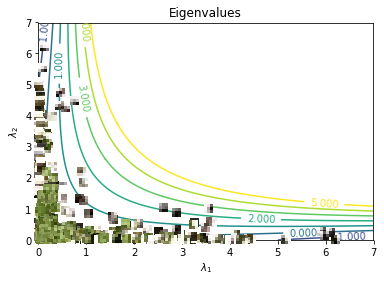

In [14]:
from copy import copy, deepcopy
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_eigenvalues(Harris, Ixx, Iyy, Ixy, BGR, k=0.04, IMAGE_PATCHES=False):

    height = BGR.shape[0]
    width = BGR.shape[1]
    
    threshold = 5E3 / (height* width)
    print(f'Threshold = {threshold}')
    
    fig, ax = plt.subplots()
    alpha = np.arange(0, 7, 0.01)
    beta = np.arange(0, 7, 0.01)
    [X,Y] = np.meshgrid(alpha, beta)
    R = X * Y - k * (X+Y)**2
    levels = np.arange(-3, 6, 1)
    cs = plt.contour(X, Y, R, levels)
    plt.clabel(cs, levels)
    
    N = height * width
    N_10 = np.ceil(N / 10)
    i = 0
    
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            #print(f'{x}, {y}')
            
            i += 1
            if(i % N_10 == 0):
                p = np.floor(i / N_10) * 10
                print(f'{p} procent')
            
            dx2 = Ixx[y,x]
            dy2 = Iyy[y,x]
            dxdy = Ixy[y,x]
            
            M = np.asarray([[dx2, dxdy],[dxdy, dy2]])
            ev = np.linalg.eigvals(M)
            alpha = ev[0]
            beta = ev[1]
            
            det = dx2 * dy2 - dxdy * dxdy
#            if(detA[y,x] != 0):
#                print(f'detA[{y},{x}] = {detA[y,x]}, det = {det}')
            
            r = np.random.rand(1)
            if(det != 0 and r < threshold):
                plt.plot(alpha, beta, 'kx')
                
                if(IMAGE_PATCHES):
                    Patch = BGR[y-1:y+2, x-1:x+2]
                    RGB = deepcopy(Patch)
                    RGB[:,:,0] = Patch[:,:,2]
                    RGB[:,:,2] = Patch[:,:,0]
                    patch = OffsetImage(RGB, zoom=3)  
                    ab = AnnotationBbox(patch, (alpha, beta), frameon=False)
                    ax.add_artist(ab)
    plt.xlabel('$\lambda_1$')
    plt.ylabel('$\lambda_2$')
    plt.title('Eigenvalues')
    print(f'{100.0} procent')

plot_eigenvalues(Harris, Ixx, Iyy, Ixy, BGR, k=0.04, IMAGE_PATCHES=True)

3. Try out different values of $k$ (default $0.04$) and run the script below. What is the effect of a higher $k$? 

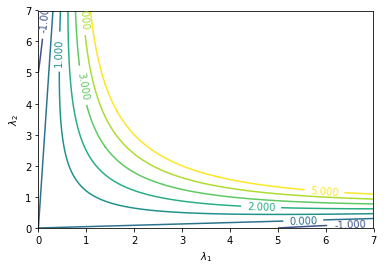

In [13]:
def plot_Harris_function(k=0.04):
    
    plt.figure()
    alpha = np.arange(0, 7, 0.01)
    beta = np.arange(0, 7, 0.01)
    [X,Y] = np.meshgrid(alpha, beta)
    R = X * Y - k * (X+Y)**2
    levels = np.arange(-3, 6, 1)
    cs = plt.contour(X, Y, R, levels)
    plt.clabel(cs, levels)
    plt.xlabel('$\lambda_1$')
    plt.ylabel('$\lambda_2$')
    
plot_Harris_function(k=0.04)

## References

[1] Lucas, B. and Kanade, T. **An iterative image registration technique with an application to stereo vision.** In proceedings of Imaging understanding workshop, pp. 121–130. 1981.

[2] Harris, C., & Stephens, M. (1988, August). **A combined corner and edge detector.** In Alvey vision conference (Vol. 15, p. 50).

[3] Moravec, H, **Obstacle Avoidance and Navigation in the Real World by a Seeing Robot Rover**, Tech Report CMU-RI-TR-3, Carnegie-Mellon University, Robotics Institute, September 1980

[4] Muthukrishnan, https://muthu.co/harris-corner-detector-implementation-in-python/


## Answers

<font color='red'><B>Exercise 1.</B></font>

1. The worst outcome happens at $x= 0$, where $f'(x) = 0$. If the actual gradient $\frac{\delta f}{ \delta x}$ were used, it would lead to a division by 0. Also, when $f$ and $g$ intersect, the shift will be estimated as $0$.

2. When selecting a linear function with a 0 slope, $f'(x) = 0$ and the estimate is always wrong (actually leads to a division by zero in the current code). This corresponds to a uniform texture in the image (e.g., part of a white wall). When selecting the `sine_slope` function with 0 slope, shifts bigger than half the period will lead to wrong estimates. This corresponds to repetitive texture in images. Even when adding a slope, like of 0.5, the method will start to estimate the wrong direction when surpassing the threshold, due to the local minima in the function.

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

def fun(x, offset=10, slope = -0.5, a = 1, fun_type = 'sine_slope'):    
    
    if(fun_type == 'sine_slope'):
        y = offset + slope * x + np.sin(a * x)
    elif(fun_type == 'quadratic'):
        y = offset + slope * x + a * x**2
    elif(fun_type == 'linear'):
        y = offset + slope * x
        
    return y
        
def fun_dx(x, offset=10, slope = -0.5, a = 1, fun_type = 'sine_slope'):    
    
    if(fun_type == 'sine_slope'):
        dy_dx = slope + a * np.cos(a * x)
    elif(fun_type == 'quadratic'):
        dy_dx = slope + 2* a * x
    elif(fun_type == 'linear'):
        dy_dx = slope
    
    return dy_dx
    
def fun_dx2(x, offset=10, slope = -0.5, a = 1, fun_type = 'sine_slope'):    
    
    if(fun_type == 'sine_slope'):
         dy_dxdx = -a*a * np.sin(a * x)
    elif(fun_type == 'quadratic'):
         dy_dxdx = 2 * a
    elif(fun_type == 'linear'):
        dy_dxdx = 0
        
    return dy_dxdx

# properties of the function

#fun_type = 'quadratic'
#offset= 10
#slope = 0
#a = 2
#dx = 0.5

#fun_type = 'linear'
#offset= 0
#slope = 0
#a = 0
#dx = 0.5

fun_type = 'sine_slope'
offset= 5
slope = 0 #0.5
a = 5
# ground-truth shift:
dx = 2*np.pi/(a*2) # + 0.1

# range in which we show the function:
max_x = 3
step = 0.01 

# We take a simple 1D function and shift it in the x-axis:
x = np.arange(-max_x, max_x, step)
f = fun(x, offset, slope, a, fun_type)
g = fun(x+dx, offset, slope, a, fun_type)

# Plot the functions
plt.figure()
plt.plot(x, f, x, g)
plt.xticks(np.arange(-max_x, max_x,1))
plt.grid()
plt.legend(['f', 'g'])
plt.show()

# x coordinate at which we apply Eq. 4:
x_query = 0

# Determine f'(x) and apply Eq. 4:
small = 0.01
df_dx = (fun(x_query+small, offset, slope, a, fun_type) - fun(x_query, offset, slope, a, fun_type)) / small
h = (fun(x_query+dx, offset, slope, a, fun_type) - fun(x_query, offset, slope, a, fun_type)) / df_dx

# Output result:
print(f'Lucas and Kanade say that the shift at {x_query} = {h}, while the ground truth is {dx}')
print(f'Approximation df/dx = {df_dx}, real value = {fun_dx(x_query, offset, slope, a, fun_type)}')
print(f'df/dx({x_query}) = {fun_dx(x_query, offset, slope, a, fun_type)}, df/dx2({x_query}) = {fun_dx2(x_query, offset, slope, a, fun_type)}')

<font color='red'><B>Exercise 2.</B></font>

1. In most cases the window works well, but even for the simple quadratic function, it still works rather badly when $f'(x) = 0$.

<font color='red'><B>Exercise 3.</B></font>

1. Yes, it is solved. Pixels with $f'(x)=0$ are not taken into account in the new weighing. A division by zero could still happen, but only if there is no gradient in any of the pixels. In that case, the input is completely constant and flow cannot be determined.

<font color='red'><B>Exercise 4.</B></font>
1. The error in the code lies in the determination of Ixx, Ixy, Iyy: they need to be convolved with a Gaussian kernel. Without this convolution, the determinant is always zero: $\mathrm{det(M)=I_x I_x I_y I_y - I_x I_y I_x I_y = 0}$.

Text(0.5, 1.0, 'Corners in red, lines in blue')

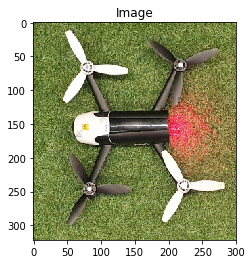

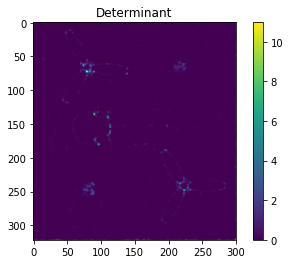

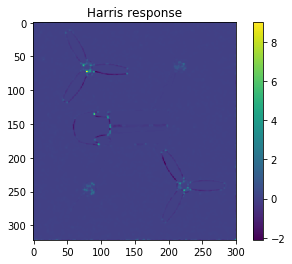

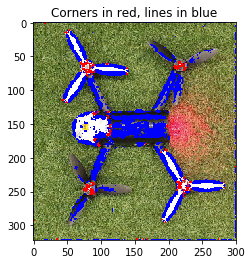

In [11]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import signal

def gradient_x(imggray):
    # Sobel kernel for Ix.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return signal.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    # Sobel kernel for Iy:
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return signal.convolve2d(imggray, kernel_y, mode='same')

def non_maximum_suppression(Harris, dist = 1, threshold_factor = 0.05):
    # suppress non maxima:
    max_H = np.max(Harris[:])
    threshold = threshold_factor * max_H
    
    Corners = np.zeros([Harris.shape[0], Harris.shape[1]])
    for x in range(1, Harris.shape[1]-1):
        for y in range(1, Harris.shape[0]-1):
            if Harris[y,x] >= threshold:
                Harris[y-dist:y+dist+1, x-dist:x+dist+1] = 0 # suppress neighbors
                Corners[y,x] = 1 # indicate corner
    return Corners

def get_Harris_vectorized(filename, k = 0.04):
    # load the BGR color image:
    BGR = cv2.imread(filename)
    gray = cv2.cvtColor(BGR, cv2.COLOR_BGR2GRAY)
    height = gray.shape[0]
    width = gray.shape[1]
    
    # resize if too big:
    if(height * width >= 1E5):
        gray = cv2.resize(gray, (int(width/4), int(height/4)))
        BGR = cv2.resize(BGR, (int(width/4), int(height/4)))
        height = gray.shape[0]
        width = gray.shape[1]
    
    # float representation, illuminance in [0,1]
    gray_float = gray.astype(float) / 255.0
    
    # get gradients:
    I_x = gradient_x(gray_float)
    I_y = gradient_y(gray_float)
    
    # Ixx, Iyy, Ixy:
    Ixx = scipy.ndimage.gaussian_filter(I_x**2, sigma=1)
    Ixy = scipy.ndimage.gaussian_filter(I_y*I_x, sigma=1)
    Iyy = scipy.ndimage.gaussian_filter(I_y**2, sigma=1)
    
    # determinant
    detA = Ixx * Iyy - Ixy ** 2
    
    # trace
    traceA = Ixx + Iyy
    
    # Harris response value:
    Harris = detA - k * traceA ** 2

    return [Harris, Ixx, Iyy, Ixy, BGR, detA, traceA, I_x, I_y]

[Harris, Ixx, Iyy, Ixy, BGR, detA, traceA, I_x, I_y] = get_Harris_vectorized('bebop.png')

#  plot matrices  for inspection and debugging:
plt.figure()
plt.imshow(cv2.cvtColor(BGR, cv2.COLOR_BGR2RGB))
plt.title('Image')

plt.figure()
plt.imshow(detA)
plt.colorbar()
plt.title('Determinant')

plt.figure()
plt.imshow(Harris)
plt.colorbar()
plt.title('Harris response')

plt.figure()
Corners = non_maximum_suppression(Harris)
Corners = scipy.ndimage.binary_dilation(Corners)
BGR_corners = BGR.copy()
BGR_corners[Corners > 0] = [0,0,255]
BGR_corners[Harris < 0] = [255,0,0]
plt.imshow(cv2.cvtColor(BGR_corners, cv2.COLOR_BGR2RGB))
plt.title('Corners in red, lines in blue')

2. It takes a long time to calculate the eigenvalues for all pixels. The trace and determinant are very easy to calculate. Since they are related to the eigenvalues, i.e.,  $\mathrm{det}(M) = \lambda_1 \lambda_2$ and $\mathrm{tr}(M) = \lambda_1 + \lambda_2$, they still capture the principal curvature of the image patch. 

3. A higher $k$ leads to a larger region where $R < 0$, so is stricter for the acceptance of a patch as a corner.